# Using  `secsy` to solve the 2D steady state continuity equation


The steady-state continuity equation for ionospheric plasma is 

\begin{equation}
    \nabla\cdot(\mathbf v n) = P - L,
\end{equation}

where $\mathbf{v}$ is the (assumed to be known) 2-dimensional (2D) velocity, $n$ is the plasma density, $P$ is the production rate, and $L$ is the loss rate. All quantities are functions of 2D space. I will assume that the flow is incompressible, and also that the loss term is proportional to the density: $L = \alpha n$, where $\alpha$ is the loss rate. The equation then becomes

\begin{equation}
    \mathbf{v} \cdot \nabla n + \alpha n = P.
\end{equation}

We see from the simplified continuity equation that in regions where the velocity is zero: $n = P/\alpha$. 

We will solve the equation using finite differences. To do that, we formulate it as a matrix equation. From now on, all vectors (bold symbols) represent the set of values of a particular quantity on a grid with $N$ cells. For example, $\mathrm{\underline{n}}$ is a set of $N$ plasma densities defined in the center of the $N$ grid cells (indicated by the underline). The matrix version of the above continuity equation can be written as

\begin{equation}
    \mathrm{diag}(\mathrm{\underline{v}}_e) \mathbb D_e \mathrm{\underline{n}} + \mathrm{diag}(\mathrm{\underline{v}}_n) \mathbb D_n \mathrm{\underline{n}} + \alpha \mathbb I \mathrm{\underline{n}} = \mathrm{\underline{P}},
\end{equation}

where subscripts $e$ and $n$ refer to the eastward and northward directions, respectively. $\mathbb I$ is the $N\times N$ identity matrix. The matrices $\mathbb D_e$ and $\mathbb D_n$, when multiplied by a vector like $\mathrm{\underline{n}}$ (that represents a scalar field on the $N$ grid cells), yields the eastward and northward components of the gradient of that quantity, respectively. That is, the matrices contain the finite difference scheme. Collecting terms with $\mathrm{\underline{n}}$:

\begin{equation}
    \left(\mathrm{diag}(\mathrm{\underline{v}}_e) \mathbb D_e + \mathrm{diag}(\mathrm{\underline{v}}_n) \mathbb D_n + \alpha \mathbb I \right)\mathrm{\underline{n}} = \mathrm{\underline{P}},
\end{equation}

which can be inverted for $\mathrm{\underline{n}}$ under some conditions. 

In the `secsy` module,  $\mathbb D_e$ and $\mathbb D_n$ can be calculated with the `get_Le_Ln` function. An arbitrarily large stencil can be used. Note that, the matrices returned by this function imply open boundary conditions, which puts restrictions on what kind of problem can be solved in this way. In our case, it works because we make the domain large enough that, in our region of interest, there is no plasma flow in or out. 

Below we will
 1. Set up the grid
 2. Read a [Weimer (2005a](https://doi.org/10.1029/2004JA010884)[,b)](https://doi.org/10.1029/2005JA011270) model output file and calculate $\mathbf{v}$ on the grid
 3. Define a production rate on each grid cell, $\mathrm{\underline{P}}$
 4. Solve and plot (given some loss rate $\alpha$)
 
Import relevant modules:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lompe
from scipy.interpolate import griddata
from scipy import sparse
from scipy.ndimage import median_filter
from scipy.sparse.linalg import spsolve
from lompe.dipole.dipole import sph_to_car

RE = 6371.2e3          # Earth's radius [m]
HI = 110e3             # ionospheric altitude [m]
B0 = 3.12e-5           # mean magnetic field, assumed to be radial
stencil_size = 2       # size of the stencil used for numerical differentiation
P0 = 1                 # plasma production rate at the subsolar point (not realistic, but we show normalized results)
alpha = 1 / (3* 60**2) # time in seconds for plasma to decay by a factor 1/e

#### Cubed sphere grid

We set up a cubed sphere grid centered at the (magnetic) north pole. The grid covers a 18 000 km$\times$18 000 km region, has a resoultion of 20 km, and it set at the ionospheric altitude of 110 km.

In [2]:
L, W, Lres, Wres = 18000e3, 18000e3, 20e3, 20e3 # [m]
projection = lompe.cs.CSprojection((0, 90.), 0)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = RE+HI, wshift=Wres//2)
SKIP = 20 # how many grid points to skip when plotting vector fields

#### Velocity field

Next, we read [Weimer (2005a](https://doi.org/10.1029/2004JA010884)[,b)](https://doi.org/10.1029/2005JA011270) model file (empirical ionospheric electric potential pattern for solar wind velocity 350 km/s, IMF $B_y$ = 0 nT, $B_z=-4$ nT, solar wind density 2 particles per cm$^3$, and dipole tilt angle $25^\circ$), add cororotation to move to a Sun-fixed frame, and calculate $\mathbf v$ on the grid, assuming a dipole magnetic field. Note that we have to interpolate the potential to the cubed sphere grid, and then smooth the electric field. 

In [3]:
# read potential file:
weimer = pd.read_table('./datasets/weimer.txt', sep = ' ', skipinitialspace=True, comment = '#', 
                       names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# prepare to differentiate to get electric field components
latxx = weimer.mlat.values.reshape((181, 61))[:, 0:]
lonxx = weimer.mlt. values.reshape((181, 61))[:, 0:] * 15  # mlt to lon
Phi   = weimer.phi .values.reshape((181, 61))[:, 0:] * 1e3 # kV to V
# altitude of potential is at around 110 km

# interpolate potential to cubedsphere grid
xi, eta = grid.projection.geo2cube(lonxx, latxx)
Phi     = griddata((xi.flatten(), eta.flatten()), Phi.flatten(), (grid.xi.flatten(), grid.eta.flatten()), 
                   fill_value = 0, method = 'cubic').reshape(grid.shape)

#### Correcting for the "corotation electric potenital"

The Weimer potential is given in a rotating frame, but we need the convection in an inertial (Sun-fixed) frame. To do that, we add the corotation electric potential to Weimer potential. The corotation electric potential at radius $R_I$ can be written as:
    
\begin{equation}
    \Phi_C = - B_0 \cdot \mathrm{R}_\mathrm{I}^2 \cdot \cos^2{\theta} \cdot \frac{2\pi}{24\ \mathrm{hr}},
\end{equation}

where we have assumed a dipole magnetic field with mean magnetic field $B_0$. Add this to the Weimer potential:

In [4]:
Phi = Phi - B0 * grid.R**2 * np.cos(grid.lat * np.pi  / 180)**2 * 2 * np.pi / (24 * 60**2)

The electric potential $\Phi$ describes the ionospheric electric field, $\mathbf{E} = -\nabla\Phi$:

In [5]:
# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_n = -Dn.dot(Phi.flatten()).reshape(grid.shape)
E_e = -De.dot(Phi.flatten()).reshape(grid.shape)

# smooth the electric field a bit:
E_e = median_filter(E_e, size = 4*SKIP, mode = 'constant', cval = 0)
E_n = median_filter(E_n, size = 4*SKIP, mode = 'constant', cval = 0)

E_n[grid.lat < 60] = 0 # set to zero flow somewhere below the Heppner-Maynard boundary

Meaningful results are only within closed contours, due to the boundary conditions implied by the forward/background differentiation near the edges of the `CSgrid` in the differentiation matrices. We therefore mask densities equatorward of 60$^{\circ}$.

The $\mathbf{E}\times\mathbf{B}$ convection velocity is described through:
\begin{equation}
    \mathbf{v}_{\mathrm{E\times B}}=\frac{\mathbf{E}\times\mathbf{B}}{|\mathbf{B}|^2}
\end{equation}
and we use this to get the velocity field $\mathbf{v}$.

In [6]:
# calculate dipole magnetic field radial components and absolute values
B_r = -2 * B0 * np.sin(grid.lat * np.pi / 180) 
B   =      B0 * np.sqrt(1 + 3 * np.sin(grid.lat * np.pi / 180)**2)

# calulate velocity components 
v_e =  E_n * B_r/B**2
v_n = -E_e * B_r/B**2

#### Plasma production, $P$

The next step is to define a production pattern. I will assume that the production is dependent on the solar zenith angle $\chi$, and calculate the solar zenith angle with some made-up latitude for the subsolar point. The plasma production is 
\begin{equation}
    P = P_0\cos{\chi},
\end{equation}
where $P_0$ is plasma production rate at the subsolar point (note that the number we use is not realistic, but we show normalized results).

In [7]:
def get_sza(lat, lon, sslat):
    """ 
    Return solar zenith angle, in radians
    maximum value is pi/2.

    lat is the latitudes where we evaluate the sza
    lon is the *local times* where we evaluate the sza

    sslat is the latitude of the subsolar point
    """
    
    shape = lat.shape
    colat = (90 - lat).flatten() 
    lt    = lon.flatten()/15

    sslt = 12

    # compute and return the angle
    ssr = sph_to_car(np.vstack((np.ones_like(sslat), 90. - sslat, sslt * 15)), deg = True)
    gcr = sph_to_car(np.vstack((np.ones_like(colat),  colat  , lt * 15 )), deg = True)

    # the angle is arccos of the dot product of these two vectors
    sza = np.arccos(np.sum(ssr*gcr, axis = 0))
    sza[sza > np.pi/2] = np.pi/2
    return sza.reshape(shape)


sza = get_sza(grid.lat, grid.lon, 10) # last number is roughly the dipole tilt angle

# plasma production
P = P0 * np.cos(sza)

#### Solve for plasma density, $n$

Now, we solve the continuity equation. Note that `get_Le_Ln` returns sparse matrices, so that we can use `scipy`'s `spsolve` function to solve the continuity equation for $n$.

In [8]:
# set up matrices
I  = sparse.identity(grid.size)
Ve = sparse.diags(v_e.flatten())
Vn = sparse.diags(v_n.flatten())
# use the differentiation matrices De, Dn from before

# solve conituity equation:
G = Ve * De + Vn * Dn + alpha * I
n = spsolve(G, P.flatten())

# mask the density below the zero-flow boundary
n[grid.lat.flatten() < 60] = np.nan

# normalize the result relative to peak density for v = 0
n = n / (P0 / alpha) 

#### Plotting

Finally, we plot the input and output.

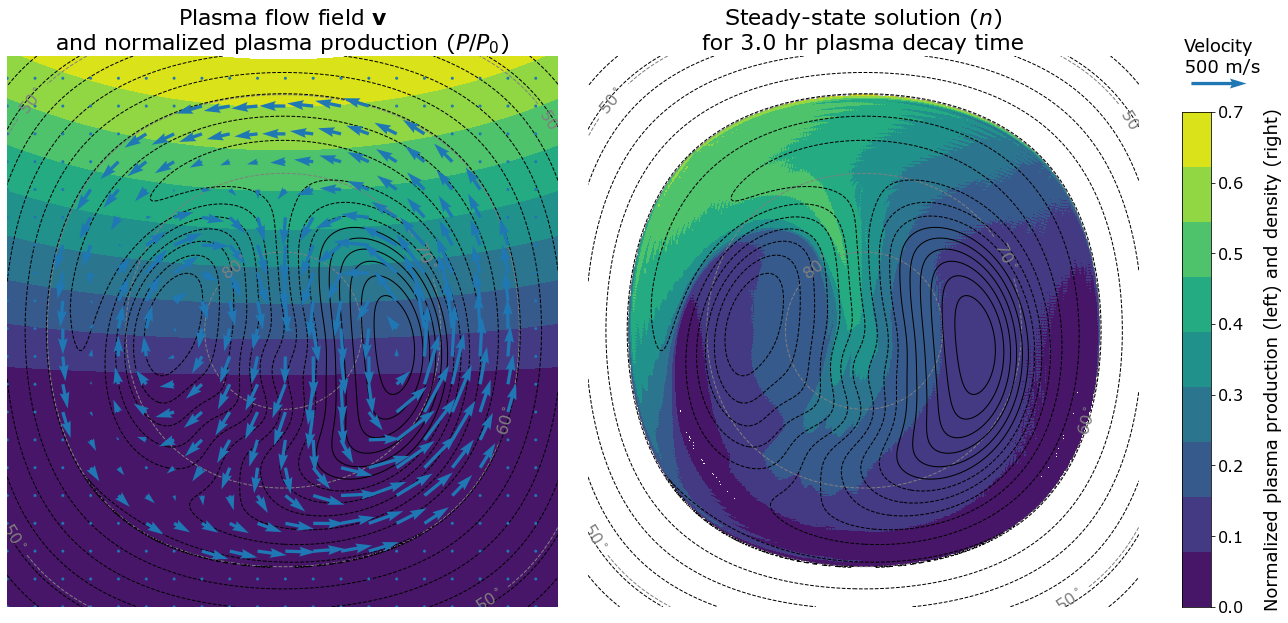

In [11]:
# set up figure and axes
fig = plt.figure(figsize = (18, 9))
axes = [plt.subplot2grid((1, 21), (0, i*10), colspan = 10) for i in [0, 1]]
cbar = plt.subplot2grid((10, 41), (1, 40), rowspan = 9)

clevels = np.linspace(0, .7, 10)          # color levels for the relative density
ncols = clevels.size
potlevels = np.r_[-100:101:4]*1e3         # levels for equipotential contours
latargs = {'linestyles':'--', 'colors':'grey', 'linewidths':1, 'levels':np.r_[-80:81:10]}

# plot "input": electric potential, velocities, and production
c=axes[0].contour(grid.xi, grid.eta, grid.lat, **latargs) # magnetic latitude
axes[0].clabel(c, c.levels, inline=True, fontsize=16, fmt='%1.0f$^\circ$')

axes[0].contour( grid.xi, grid.eta, Phi, colors='black', levels=potlevels, linewidths=1) # electric potential
axes[0].contourf(grid.xi, grid.eta, P.reshape(grid.shape) / P0, levels=clevels) # normalized plasma production

vxi, veta = grid.projection.vector_cube_projection(v_e.flatten(), v_n.flatten(), grid.lon.flatten(), grid.lat.flatten(), 
                                                   return_xi_eta=False)
vxi, veta = vxi.reshape(grid.shape), veta.reshape(grid.shape)

# velocity field
q = axes[0].quiver(grid.xi[::SKIP, ::SKIP], grid.eta[::SKIP, ::SKIP], vxi[::SKIP, ::SKIP], veta[::SKIP, ::SKIP], 
                   scale=5000, color='C0', width=.006, zorder=3)
qkey = {'X':2.2, 'Y':.95, 'U':500, 'label':"Velocity\n 500 m/s", 'labelpos':'N', 
        'fontproperties':{'size':18}, 'zorder':3} # quiver key properties
axes[1].quiverkey(q, **qkey)

axes[0].set_aspect('equal')
axes[0].set_axis_off()
axes[0].set_title('Plasma flow field $\mathbf{v}$\nand normalized plasma production ($P/P_0$)', fontsize=22)


# plot "output": solution (and "input" electric potential)
co=axes[1].contour( grid.xi, grid.eta, grid.lat, **latargs) # magnetic latitude
axes[1].clabel(co, co.levels, inline=True, fontsize=16, fmt='%1.0f$^\circ$')
axes[1].contour( grid.xi, grid.eta, Phi, colors='black', levels=potlevels, linewidths=1) # electric potential
axes[1].contourf(grid.xi, grid.eta, n.reshape(grid.shape), levels=clevels) # normalized plasma density

axes[1].set_aspect('equal')
axes[1].set_axis_off()
axes[1].set_title('Steady-state solution ($n$)\nfor {0:.2} hr plasma decay time'.format(1/alpha/60**2), fontsize=22)

# plot the colorbar
cbar.contourf(np.vstack((np.zeros(ncols), np.ones(ncols))), np.vstack((clevels, clevels)), 
              np.vstack((clevels, clevels)), levels=clevels)
cbar.set_xticks([])
cbar.yaxis.tick_right()
cbar.tick_params(labelsize=16)
cbar.yaxis.set_label_position('right')
cbar.set_ylabel('Normalized plasma production (left) and density (right)', fontsize=18, va='top', labelpad=20)

fig.subplots_adjust(left=.001, right=.94, top=.9, bottom=.05, wspace=.05)
plt.show()

# save figure
fig.savefig('./output_figures/02continuityexample.pdf')
fig.savefig('./output_figures/02continuityexample.png')

The figure shows:
- Left: Input. The black contours is the electric potential from the Weimer model and corotation. Blue arrows show the resulting velocity field (above 60$^{\circ}$ magnetic latitude). The color contours show the normalized plasma production ($P/P_0$, where $P_0$ is the production at the subsolar point).
- Right: Output, i.e., the steady-state solution for plasma density $n$ (normalized by dividing by $P_0/\alpha$, which is the density at the subsolar point given no transport). We are assuming a 3 hour plasma decay time, i.e., $\alpha=1/(3\ \mathrm{hr})$, as color contours. The black contours is the electric potential from the Weimer model.